In [504]:
from IPython import display
import math
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import sys
import csv
import tweepy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

In [505]:
#access data from S3 Bucket
from sagemaker import get_execution_role
role = get_execution_role()
import boto3
s3_client = boto3.client('s3')
data_bucket_name='mishalmf'
obj_list=s3_client.list_objects(Bucket=data_bucket_name)
file=[]
for contents in obj_list['Contents']:
    file.append(contents['Key'])
    
## open a csv file to store the Tweets and their sentiment 
file_name = 'Sentiment_Analysis_download.csv'

with open(file_name, 'w', newline='') as csvfile:
   csv_writer = csv.DictWriter(
       f=csvfile,
       fieldnames=["Tweet", "Sentiment"]
   )
   csv_writer.writeheader()



In [506]:
import praw

reddit = praw.Reddit(client_id='uuLwZTQwVHfQTg',
                     client_secret='wpV0IGR3jOYuXSoMHI7ghgRWhYY',
                     user_agent='mish_franc')

In [507]:
political_news = set()

In [508]:
for submission in reddit.subreddit('politics').new(limit=None):
    political_news.add(submission.title)
    display.clear_output()
    print(len(political_news))

954


In [509]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()

In [510]:
results = []

for line in political_news:
    pol_score = sia.polarity_scores(line)
    pol_score['news'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'compound': 0.5859,
  'neg': 0.0,
  'neu': 0.758,
  'news': "Trump Biographer: Looks Like The President ‘Knows He’s Bleeped’ And 'Something Is About "
          "To Hit The Fan'",
  'pos': 0.242},
 {'compound': 0.2263,
  'neg': 0.166,
  'neu': 0.613,
  'news': 'EPIC Makes Final Arguments to Supreme Court in Voter Data Privacy Case',
  'pos': 0.221},
 {'compound': -0.2732,
  'neg': 0.151,
  'neu': 0.754,
  'news': 'Probe of U.S.-funded news network that called George Soros a ‘Jew of flexible morals’ '
          'finds additional offensive content',
  'pos': 0.095}]


In [511]:
df = pd.DataFrame.from_records(results)
df.head()

,compound,neg,neu,news,pos
0,0.5859,0.000,0.758,Trump Biographer: Looks Like The President ‘Kn...,0.242
1,0.2263,0.166,0.613,EPIC Makes Final Arguments to Supreme Court in...,0.221
2,-0.2732,0.151,0.754,Probe of U.S.-funded news network that called ...,0.095
3,-0.0516,0.146,0.854,Tim Ryan backs term limits deal with Pelosi,0.000
4,-0.0258,0.291,0.427,Prosecutors have a strong criminal case agains...,0.282


In [512]:
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

,compound,neg,neu,news,pos,label
0,0.5859,0.000,0.758,Trump Biographer: Looks Like The President ‘Kn...,0.242,1
1,0.2263,0.166,0.613,EPIC Makes Final Arguments to Supreme Court in...,0.221,1
2,-0.2732,0.151,0.754,Probe of U.S.-funded news network that called ...,0.095,-1
3,-0.0516,0.146,0.854,Tim Ryan backs term limits deal with Pelosi,0.000,0
4,-0.0258,0.291,0.427,Prosecutors have a strong criminal case agains...,0.282,0


In [513]:
df2 = df[['news', 'label']]
df2.to_csv('reddit_headlines.csv', mode='a', encoding='utf-8', index=False)

In [514]:
print("Positive headlines:\n")

pprint(list(df[df['label'] == 1].news)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['label'] == -1].news)[:5], width=200)

Positive headlines:

["Trump Biographer: Looks Like The President ‘Knows He’s Bleeped’ And 'Something Is About To Hit The Fan'",
 'EPIC Makes Final Arguments to Supreme Court in Voter Data Privacy Case',
 'Defying Trump, US Senate approves Yemen resolution',
 'AMI Apparently Has a Safe Full of Trump’s Secrets, and It Sure Looks Like the Feds Have It Now',
 'Publisher of the National Enquirer admits to hush-money payments made on Trump’s behalf']

Negative headlines:

['Probe of U.S.-funded news network that called George Soros a ‘Jew of flexible morals’ finds additional offensive content',
 'Ex-Tallahassee mayor Maddox indicted in FBI investigation that hurt Gillum’s campaign',
 'Russian spy Maria Butina pleads guilty to conspiring against the US',
 "Nate Silver: Foremost reasons for GOP disdain of Ocasio-Cortez are 'her race and gender'",
 'States ask court to stop Trump from reviving US coal sales']


In [515]:
print(df.label.value_counts())

print(df.label.value_counts(normalize=True) * 100)

 0    414
-1    348
 1    192
Name: label, dtype: int64
 0    43.396226
-1    36.477987
 1    20.125786
Name: label, dtype: float64


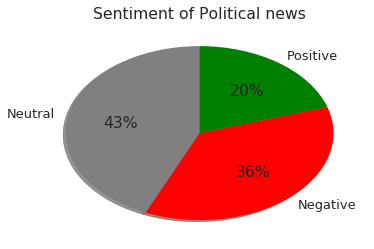

In [516]:
counts = df.label.value_counts(normalize=True) * 100

colors = ['grey', 'red', 'green']
labels = 'Neutral', 'Negative', 'Positive'

## use matplotlib to plot the chart
plt.pie(
   x=counts,
   shadow=True,
   colors=colors,
   labels=labels,
   startangle=90,
   autopct = '%i%%'
)

plt.title("Sentiment of Political news")
plt.show()

In [488]:
from nltk.tokenize import word_tokenize, RegexpTokenizer

In [489]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [490]:
def process_text(political_news):
    tokens = []
    for line in political_news:
        tok = tokenizer.tokenize(line)
        tok = [t.lower() for t in tok if t.lower() not in stop_words]
        tokens.extend(tok)
    
    return tokens

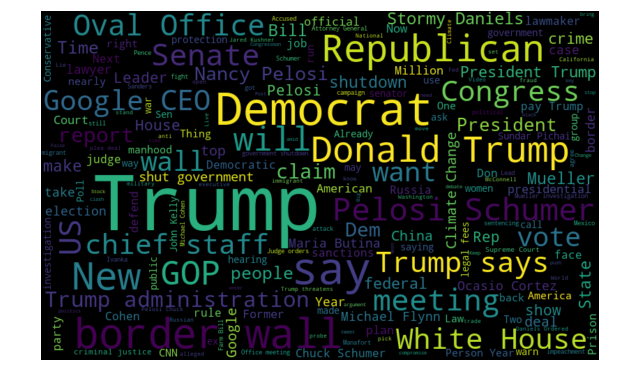

In [491]:
all_words = ' '.join([text for text in df['news']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

           Frequency
Word                
trump             72
says              15
democrats         12
party             10
border             9
tax                9
court              9
like               9
pelosi             8
supreme            8


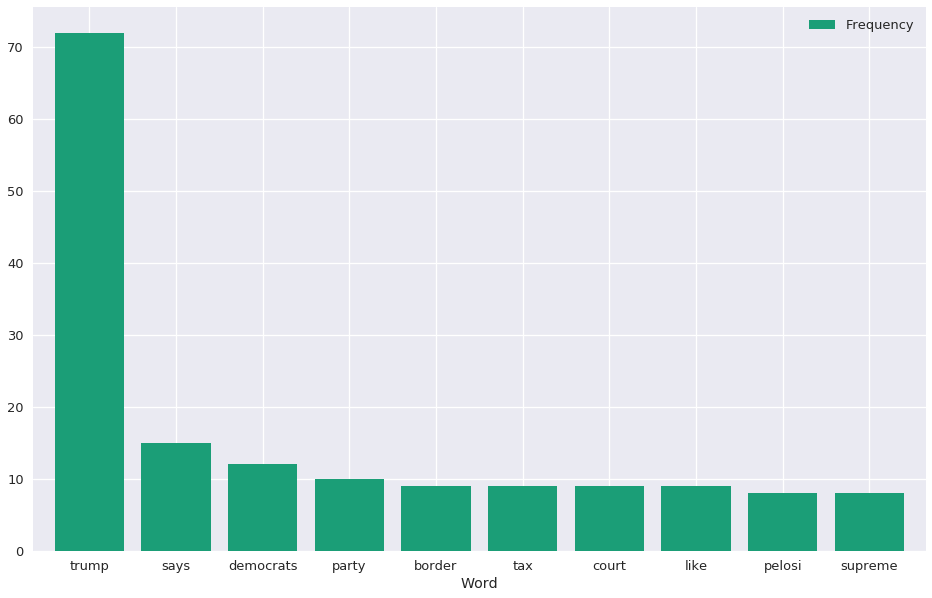

In [492]:
positive_hl = list(df2[df2.label == 1].news)

positive_tokens = process_text(positive_hl)
positive_freq = nltk.FreqDist(positive_tokens)

# generate DF out of Counter
rslt = pd.DataFrame(Counter(positive_tokens).most_common(10),
                    columns=['Word', 'Frequency']).set_index('Word')
print(rslt)

# plot
rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)


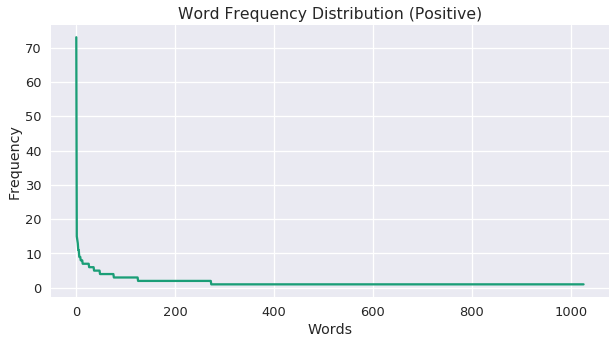

In [493]:
y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

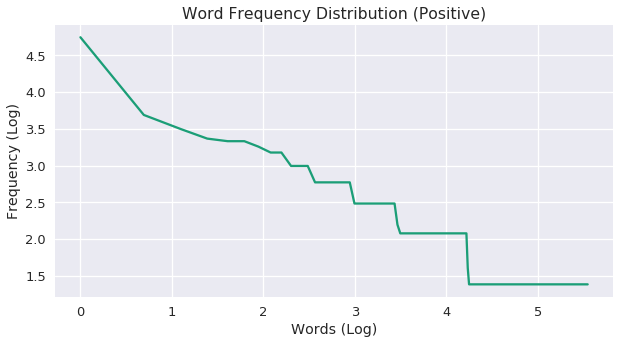

In [494]:
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

             Frequency
Word                  
trump              143
wall                31
border              25
pelosi              22
schumer             18
says                18
meeting             16
shutdown            16
republicans         14
us                  14


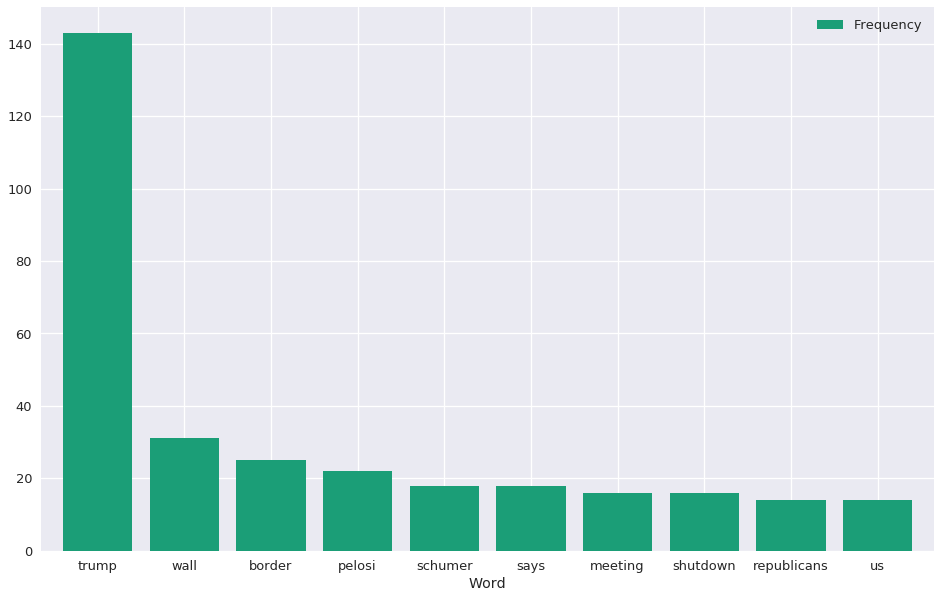

In [495]:
negative_hl = list(df2[df2.label == -1].news)

negative_tokens = process_text(negative_hl)
negative_freq = nltk.FreqDist(negative_tokens)

# generate DF out of Counter
rslt = pd.DataFrame(Counter(negative_tokens).most_common(10),
                    columns=['Word', 'Frequency']).set_index('Word')
print(rslt)

# plot
rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

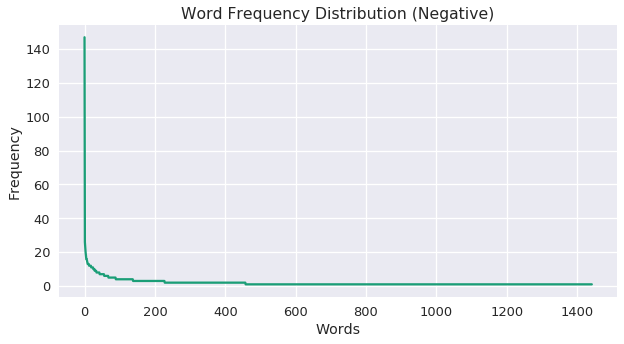

In [496]:
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

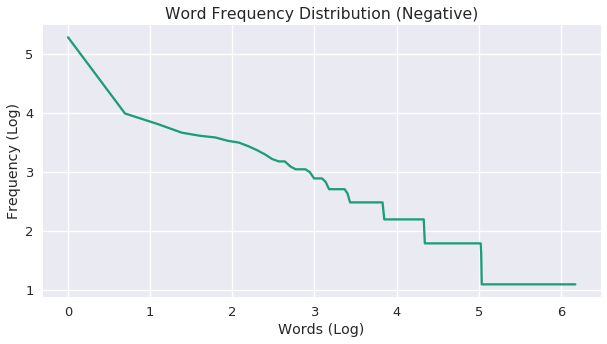

In [497]:
y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()